In [1]:
import jax
from jax.nn.initializers import orthogonal
from jax                 import random, vmap, jit, grad
from jax import numpy as jnp

seed = 42

# JAX random generator key
key = random.PRNGKey(seed)

In [2]:
N = 10000
D = 2

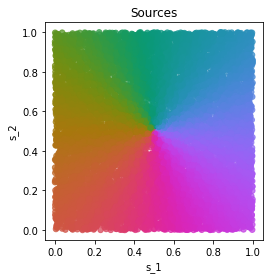

In [3]:
import cmocean
cmap = cmocean.cm.phase

S = jax.random.uniform(key, shape=(N, D), minval=0.0, maxval=1.0)
from plotting import cart2pol, pol2cart, scatterplot_variables

_, colors = cart2pol( S[:,0]-0.5, S[:,1]-0.5)

# Plot the sources
scatterplot_variables(S, 'Sources', colors=colors, savefig=False, cmap=cmap)

# Mixing with invertible residual flows. (Commented for now)

In [4]:
import distrax
import haiku as hk
from residual import TriangularResidual, spectral_norm_init, spectral_normalization, masks_triangular_weights, make_weights_triangular, LipSwish

In [5]:
import numpy as np

In [6]:
from haiku.initializers import RandomNormal# Import a different initializer

In [7]:
from metrics import cima_higher_d_fwd

In [8]:
# from typing import Any, Sequence, Union

# class RandomCauchy(hk.initializers.Initializer):
#     """Initializes by sampling from a normal distribution."""

#     def __init__(self, stddev=1., mean=0.):
#         """Constructs a :class:`RandomNormal` initializer.
#         Args:
#           stddev: The standard deviation of the normal distribution to sample from.
#           mean: The mean of the normal distribution to sample from.
#         """
#         self.stddev = stddev
#         self.mean = mean

        
#     def __call__(self, shape: Sequence[int], dtype) -> jnp.ndarray:
#         m = jax.lax.convert_element_type(self.mean, dtype)
#         s = jax.lax.convert_element_type(self.stddev, dtype)
#         return m + s * jax.random.cauchy(hk.next_rng_key(), shape, dtype)

In [9]:
# n_layers = 4 #32
# hidden_units = [15, 15]
# print("Num layers: ", n_layers)
# coef=0.9
# max_iter=100
# print("Max iter: ", max_iter)
# print()
# print()
# mean_stdev = 0.01 #variation of the mean across layers
# stdev = 0.01 #this sets the level of randomness within layers
# stdev_deviation = 0.01


# # initializer = 'None'
# # initializer = RandomNormal
# initializer = RandomCauchy

# def inv_map_fn(x):
#     flows = distrax.Chain([TriangularResidual(hidden_units + [D], name='residual_' + str(i), initializer=initializers[i])
#                            for i in range(n_layers)]
#                           )
#     return flows.inverse(x)


# for i in range(5):

#     key+=1
    
#     means =  mean_stdev * random.cauchy(key, shape=(n_layers, ))
#     stddevs = stdev + stdev_deviation * np.abs(random.cauchy(key, shape=(n_layers, )))

#     initializers = [initializer(stddev=stddevs[i], mean=means[i]) for i in range(n_layers)]
    
#     inv_map = hk.transform(inv_map_fn)
#     params = inv_map.init(key, jnp.array(np.random.randn(5, D)))

#     print("RAW MAP")
#     # Define and apply fwd transformation
#     forward_rn = lambda x : inv_map.apply(params, None, x)
    
#     X = forward_rn(S)

#     # Plot observations
#     scatterplot_variables(X, 'Observations', colors=colors, savefig=False, cmap=cmap)

#     jac_rn_batched = jax.vmap(jax.jacfwd(forward_rn))
#     c = cima_higher_d_fwd(S, jac_rn_batched)
#     print("Cima: ", jnp.mean(c))
#     print()
    
#     #### COMPARE WITH SPECTRAL NORMALISATION #####    
#     print("AFTER NORMALISATION")    
#      # Apply spectral normalization
#     uv = spectral_norm_init(params, key)
#     params, uv = spectral_normalization(params, uv, coef=coef, max_iter=max_iter)
    
#     # Define and apply fwd transformation
#     forward_rn = lambda x : inv_map.apply(params, None, x)
#     X = forward_rn(S)

#     # Plot observations
#     scatterplot_variables(X, 'Observations', colors=colors, savefig=False, cmap=cmap)

#     jac_rn_batched = jax.vmap(jax.jacfwd(forward_rn))
#     c = cima_higher_d_fwd(S, jac_rn_batched)
#     print("Cima: ", jnp.mean(c))
#     print()
#     print()

# Mixing with fully connected MLPs.

# Use `leaky_tanh` nonlinearity.

In [10]:
from scipy.stats import ortho_group # Requires version 0.18 of scipy

Alternative: Use MLP mixing.

In [11]:
import jax
import jax.numpy as jnp

from jax.experimental.stax import Dense, serial, elementwise

# def smooth_leaky_relu(x, alpha=0.001):
#     """Smoothed version of the leaky relu activation function
#     Inspiration:
#     https://stats.stackexchange.com/questions/329776/approximating-leaky-relu-with-a-differentiable-function
#     """
#     return alpha*x + (1 - alpha)*(jnp.logaddexp(x, 0))

def leaky_tanh(x, alpha=1.0, beta=0.1):
    return jnp.tanh(alpha*x) + beta*x

# Nonlinearity = elementwise(smooth_leaky_relu)
Nonlinearity = elementwise(leaky_tanh)

num_layers = 3

layers = [Dense(D, W_init=jax.nn.initializers.orthogonal()), Nonlinearity]*(num_layers - 1) + [Dense(D, W_init=jax.nn.initializers.orthogonal())]

init_random_params, MLP = serial(
    *layers
)

In [12]:
key = jax.random.PRNGKey(0)

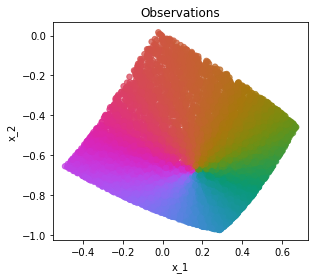

Cima:  0.058943104


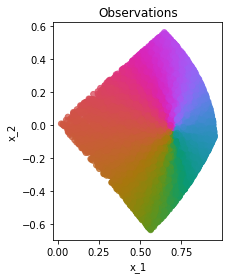

Cima:  0.14714871


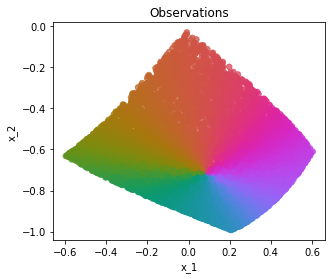

Cima:  0.090199426


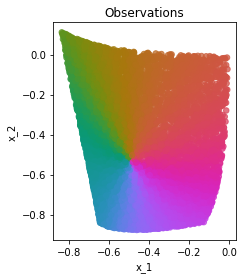

Cima:  0.08992258


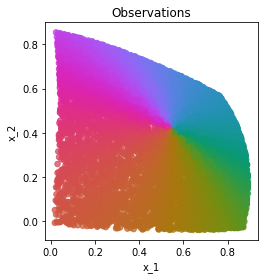

Cima:  0.17464185


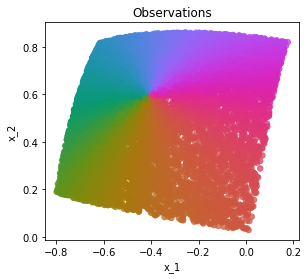

Cima:  0.06369607


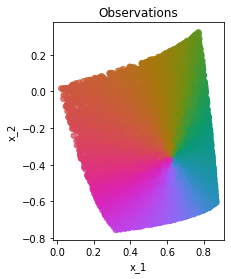

Cima:  0.067713164


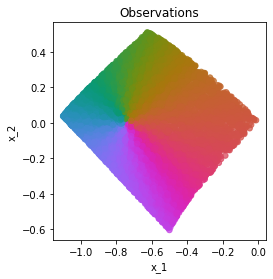

Cima:  0.0155822355


In [13]:
for j in range(8):
    key +=1

    _, params = init_random_params(key, (-1, D))

    X = MLP(params, S)

    forward_mlp = lambda x: MLP(params, x)

    jac = jax.vmap(jax.jacfwd(forward_mlp))
    J = jac(S)

    scatterplot_variables(X, 'Observations', colors=colors, savefig=False, cmap=cmap)

    c = cima_higher_d_fwd(S, jac)
    print("Cima: ", jnp.mean(c))